### Process_CoreBx_multi_v2

Read the interpolated DEMs and do volume calcs.
This version was modifed in Santa Cruz to make figure.

This reads the .nc files created by `CoreBx_multi`

TODO:
* Correct aspect ratio on maps?
* Equal axes for all line plots?
* Add labels to colorbars
* Add a), b), ...
* Remove titles?
* If the x, y labeling changes in CoreBx_multi, then correct here too.

In [40]:
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
# from dask.distributed import LocalCluster
from scipy import interpolate, signal
%matplotlib inline

# These commands choose fonts that are editable in svg format
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42

In [49]:
# define all of the functions by runnng this python file
%run -i CoreBx_funcs

<Figure size 432x288 with 0 Axes>

In [79]:

# Dates for DEMs
dates = ([\
         "30 Aug 2019",\
         "12-13 Sep 2019",\
         "11 Oct 2019",\
         "26 Nov 2019"])

# Offsets for DEM elevation corrections (should not be needed when we get to Andy's data )
offset = np.array([-.17, 0., 0., 0.])

# Make an array of dicts, where analysis region is defined by:
#  name
#  e0 - UTM Easting of origin [m]
#  n0 - UTM Northing of origin [m]
#  xlen - Length of alongshore axis [m]
#  ylen - Length of cross-shore axis [m]
#  dxdy - grid size (must be isotropic right now) [m]
#  theta - rotation CCW from x-axis [deg]
#  xs_end - number of grid cells to approximate limit of overwash terrace
#  d_end - number of grid cells to 

# This block is copied from CoreBx_multi, with addition of xs_end and d_end:

regions = [{'name':"region_1","e0": 380400.,"n0": 3858160.,"xlen": 3400.,"ylen": 600.,"dxdy": 1.,"theta": 42.,'xs_end':400,'d_end':300},
           {'name':"region_2","e0": 383440.,"n0": 3860830.,"xlen": 3990.,"ylen": 700.,"dxdy": 1.,"theta": 41.,'xs_end':300,'d_end':200},
           {'name':"region_3","e0": 386485.,"n0": 3863430.,"xlen": 1200.,"ylen": 700.,"dxdy": 1.,"theta": 44.,'xs_end':350,'d_end':200},
           {'name':"region_4","e0": 387330.,"n0": 3864280.,"xlen": 4000.,"ylen": 700.,"dxdy": 1.,"theta": 45.,'xs_end':400,'d_end':200},
           {'name':"region_5","e0": 390140.,"n0": 3867115.,"xlen": 3400.,"ylen": 700.,"dxdy": 1.,"theta": 43.75,'xs_end':350,'d_end':200},
           {'name':"region_6","e0": 392600.,"n0": 3869450.,"xlen": 2440.,"ylen": 700.,"dxdy": 1.,"theta": 42.,'xs_end':400,'d_end':200},
           {'name':"region_7","e0": 394430.,"n0": 3871065.,"xlen": 3220.,"ylen": 700.,"dxdy": 1.,"theta": 42.,'xs_end':400,'d_end':200},
           {'name':"region_8","e0": 396800.,"n0": 3873240.,"xlen": 3500.,"ylen": 700.,"dxdy": 1.,"theta": 42.,'xs_end':400,'d_end':250},
           {'name':"region_9","e0": 399400.,"n0": 3875580.,"xlen": 3300.,"ylen": 700.,"dxdy": 1.,"theta": 40.,'xs_end':450,'d_end':250}]
#regions = [{'name':"region_3","e0": 386485.,"n0": 3863430.,"xlen": 1200.,"ylen": 700.,"dxdy": 1.,"theta": 44.,'xs_end':350,'d_end':200}]

CoreBx_funcs.py:107: RuntimeWarning: Mean of empty slice
CoreBx_funcs.py:108: RuntimeWarning: Mean of empty slice


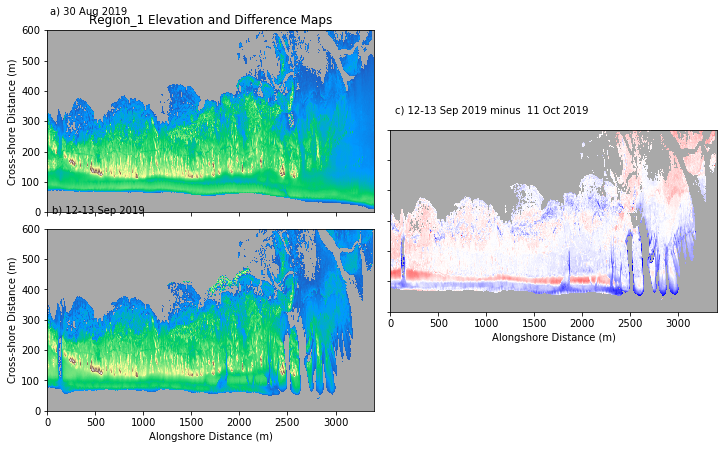

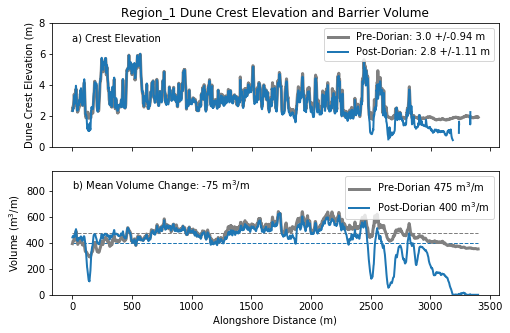

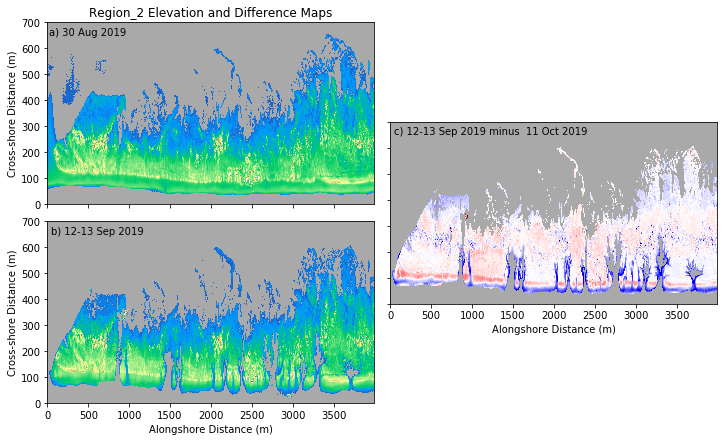

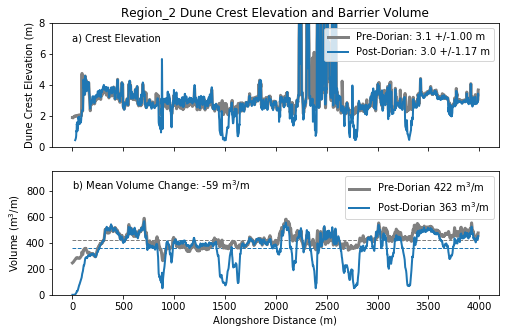

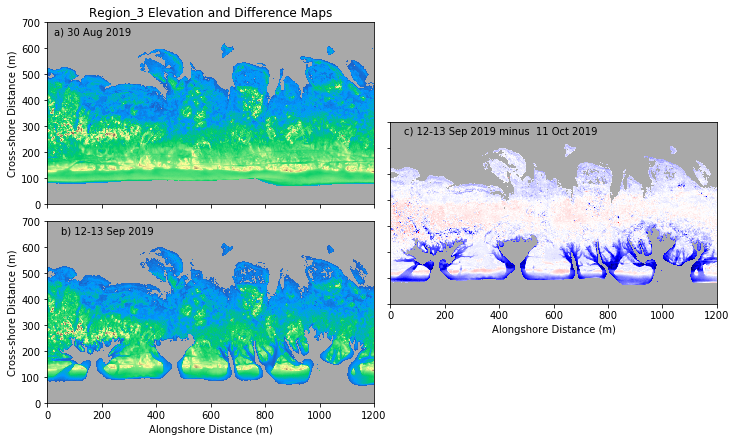

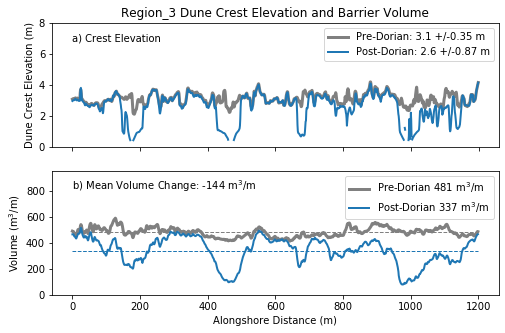

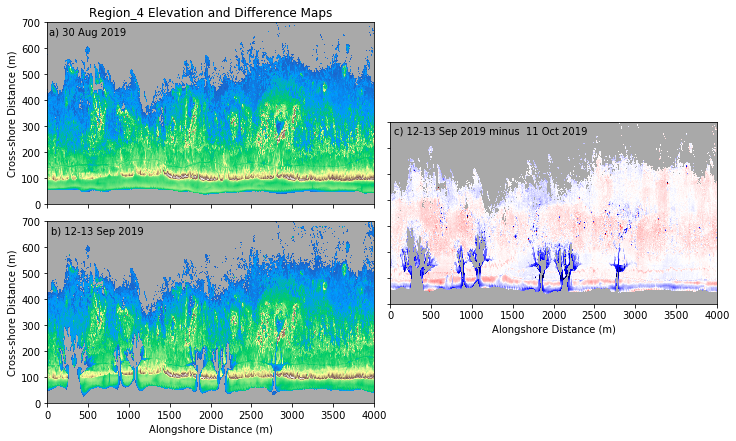

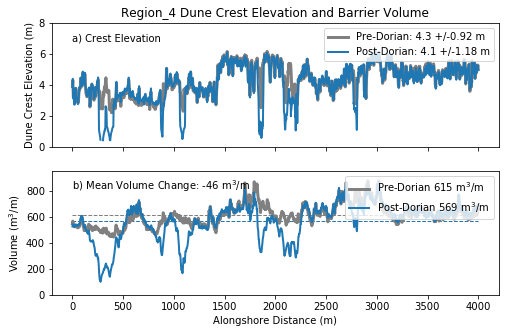

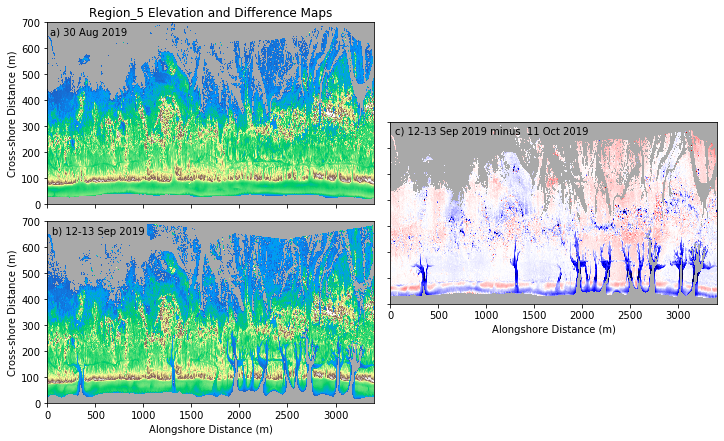

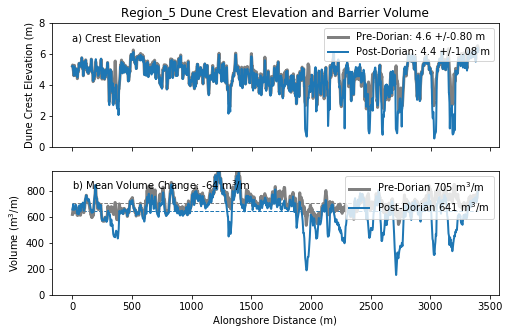

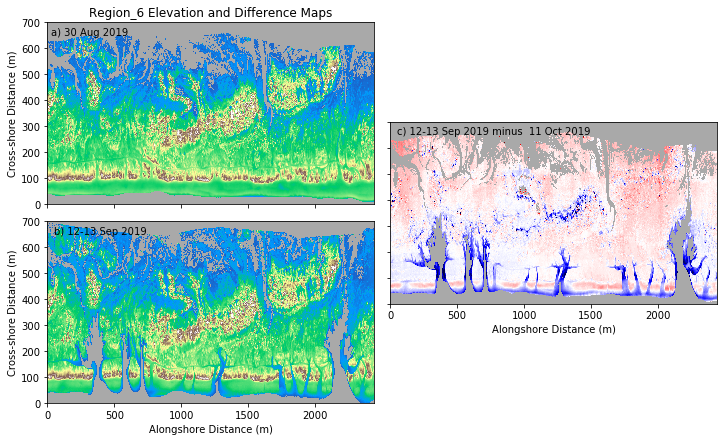

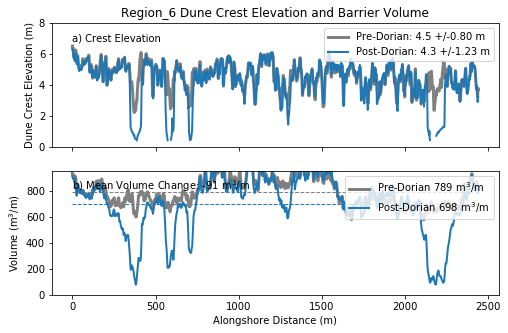

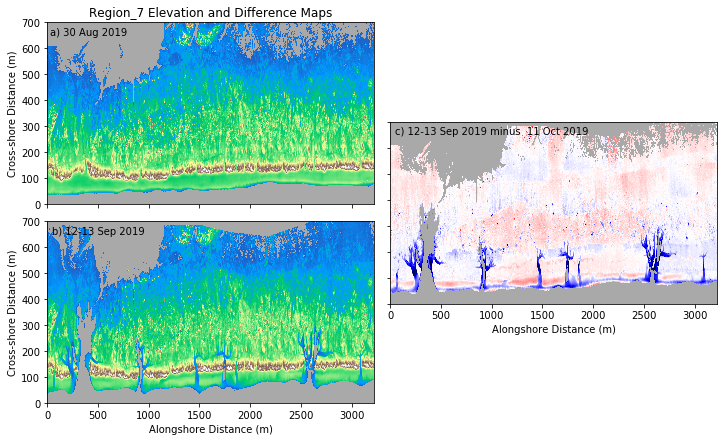

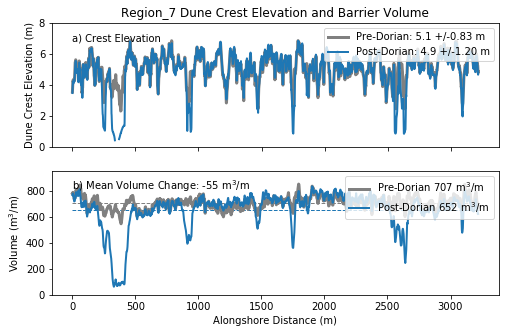

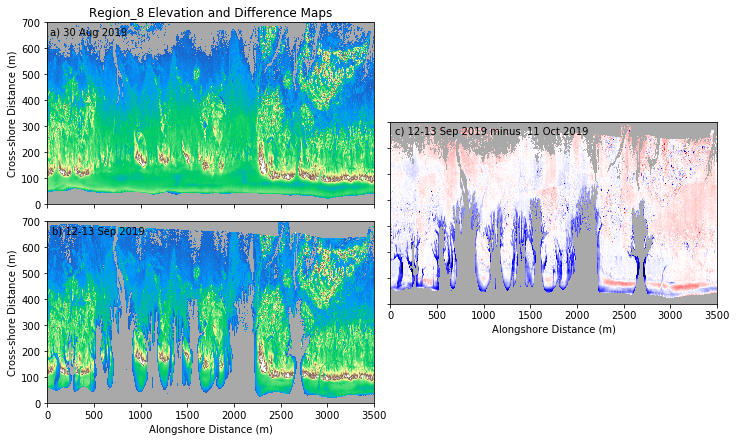

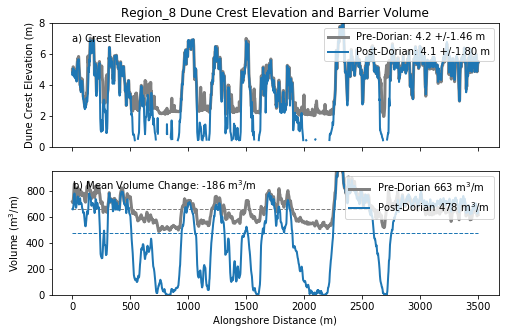

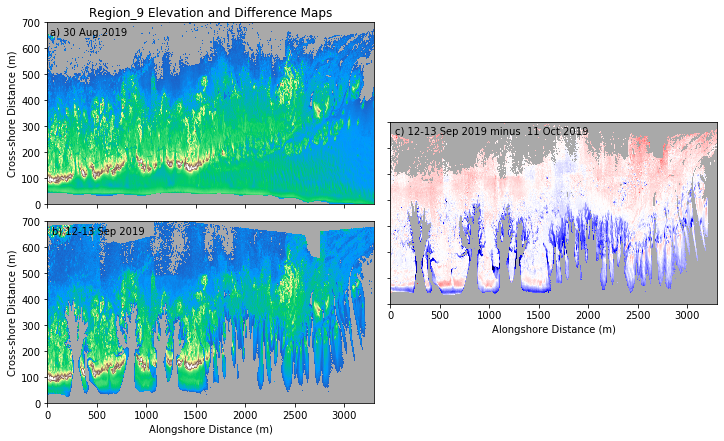

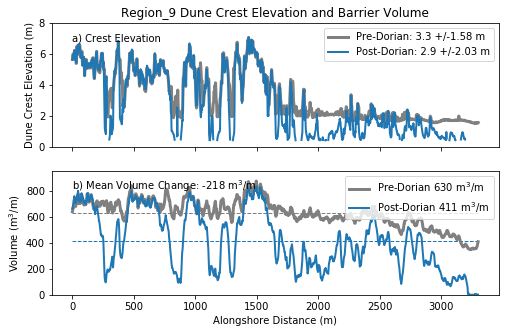

In [81]:
vsum = 0.
vsumall = 0.
vchangeall = 0.
vchange=0.
island_length=0.

sfile = open("stats.txt", "w")

for r in regions:
    print("",file=sfile)
    print(r['name'],file=sfile)
    fn = r['name']+'.nc'
    dsa = xr.open_dataset(fn)
    dsaa = np.squeeze(dsa.to_array())

    # The first SfM map is about 17 cm high...correct that.
    dsaa[0,:,:] = dsaa[0,:,:] + offset[0] 

    dsaa = dsaa.where(dsaa>=0.4)
    map_stats(dsaa,sfile)

    diffmap = np.squeeze(np.diff(dsaa,axis=0))
    print(np.shape(diffmap),file=sfile)
    print("Stats for diffmap:",file=sfile)
    map_stats2d(diffmap,sfile)

    tcmap=plt.cm.terrain
    tcmap.set_bad(color='darkgray')
    title_str = '{0:s}'.format(r['name'].capitalize())  
    
    ##############################################################################
    # Elevation and difference maps
    fig3 = plt.figure(figsize=(12,7),constrained_layout=False)
    gs = fig3.add_gridspec(4, 2, wspace=0.05)
    
    f3_ax1 = fig3.add_subplot(gs[0:2, 0])
    f3_ax1.text(25,650,'a) {}'.format(dates[0]))
    f3_ax1.xaxis.set_ticklabels([])
    plt.pcolormesh(dsaa[0,:,:],cmap=tcmap,vmin=0,vmax=6)
    plt.ylabel('Cross-shore Distance (m)')
    title_str = '{0:s} Elevation and Difference Maps'.format(r['name'].capitalize())
    plt.title(title_str)
    #plt.colorbar()


    f3_ax2 = fig3.add_subplot(gs[2:, 0])
    f3_ax2.text(50,650,'b) {}'.format(dates[1]))
    plt.pcolormesh(dsaa[1,:,:],cmap=tcmap,vmin=0,vmax=6)
    plt.xlabel('Alongshore Distance (m)')
    plt.ylabel('Cross-shore Distance (m)')

    f3_ax3 = fig3.add_subplot(gs[1:3, -1])
    f3_ax3.text(50,650,'c) {} minus  {}'.format(dates[1],dates[2]))
    f3_ax3.yaxis.set_ticklabels([])
    dcmap=plt.cm.seismic
    dcmap.set_bad(color='darkgray')
    plt.pcolormesh(diffmap[:,:],cmap=dcmap,vmin=-3,vmax=3.)
    plt.xlabel('Alongshore Distance (m)')

    fig_name = r['name']+'maps.png'
    plt.savefig(fig_name, bbox_inches='tight', dpi = 300)
    ##############################################################################


    # calculate dhi
    dblue = '#1f77b4'
    dhi = dsaa[:,0:r['d_end'],:].max(axis=1,skipna=True).values
    print(np.shape(dhi),file=sfile)
    mean_dhi = np.nanmean(dhi,1)
    std_dhi = np.nanstd(dhi,1)
    pre_str = 'Pre-Dorian: {0:.1f} +/-{1:.2f} m'.format(mean_dhi[0],std_dhi[0])
    post_str = 'Post-Dorian: {0:.1f} +/-{1:.2f} m'.format(mean_dhi[1],std_dhi[1])

    # calculate volumes
    ny,nx = np.shape(dsaa[0])
    xs_start = 0
    xs_end = r['xs_end']
    dxdy = r['dxdy']
    xs_len = (xs_end-xs_start)
    print('xs_len = ',xs_len,' alongshore length: ',nx*dxdy,file=sfile)
    
    # volumes for each transect in overwash terrace
    v = np.squeeze(np.nansum(dsaa[:,xs_start:xs_end,:],axis=1))
    # volumes for each transect across entire cell
    vall = np.squeeze(np.nansum(dsaa[:,:,:],axis=1))
    
    # respective volume differences
    vdiff = np.squeeze(np.diff(v,axis=0))
    vdiffall = np.squeeze(np.diff(vall,axis=0))
    
    # average transect volume for overwash terrace
    m = np.mean(v,1)
    # average volume change for overwash terrace
    mean_dv = np.sum(vdiff)/(nx*dxdy)
    
    print('{0:s} Mean transect volume loss: {1:.2f} m3/m'.format(r['name'],mean_dv),file=sfile)
    
    # update sum over entire island
    vsum = vsum+np.nansum(v,1)
    vsumall = vsumall+np.nansum(vall,1)
    vchange=vchange+np.sum(vdiff)
    vchangeall = vchangeall+np.sum(vdiffall)
    
    island_length = island_length+r['xlen']
    
    # calculate elevations
    mean_elev_xs_len = np.nanmean(np.nanmean(dsaa[:,0:r['xs_end'],:],1),1)
    mean_elev_all = np.nanmean(np.nanmean(dsaa,1),1)
    print("Mean elevation in overwash terrace (m):",mean_elev_xs_len,file=sfile )
    print("Mean elevation in entire region (m):",mean_elev_all,file=sfile )

    pc = 100*np.nanmean(vdiff)/np.mean(v)
    pcall = 100*np.nanmean(vdiffall)/np.mean(vall)

    print("Pct volume change in overwash terrace m:",pc,"%",file=sfile)
    print("Pct volume change in overwash terrace m:",pcall,"%",file=sfile)

    ##############################################################################
    # Elevation
    title_str = '{0:s} Dune Crest Elevation and Barrier Volume'.format(r['name'].capitalize())
    plt.figure(figsize=(8,5))
    ax1=plt.subplot(211)
    plt.plot(dhi[0,:],color='gray',linewidth=3,label=pre_str)
    plt.plot(dhi[1,:],color=dblue,linewidth=2,label=post_str)
    plt.legend(loc='upper right')
    ax1.xaxis.set_ticklabels([])
    ax1.set_ylim(0,7.5)
    plt.ylabel('Dune Crest Elevation (m)')
    plt.text(0,.85*7.5,"a) Crest Elevation")
    plt.title(title_str)
    
    # Volume plot
    ax2=plt.subplot(212)
    plt.plot([0, nx*dxdy],[m[0],m[0]],'--',color='gray',linewidth=1)
    plt.plot([0, nx*dxdy],[m[1],m[1]],'--',color='#1f77b4',linewidth=1)
    pre_str = 'Pre-Dorian {0:.0f} m$^3$/m'.format(m[0])
    post_str = 'Post-Dorian {0:.0f} m$^3$/m'.format(m[1])
    plt.plot(v[0,:],label=pre_str,color='gray',linewidth=3)
    plt.plot(v[1,:],label=post_str,linewidth=2)
    ax2.set_ylim(0,950)
    plt.xlabel(r'Alongshore Distance (m)')
    plt.ylabel(r'Volume (m$^3$/m)')
    plt.legend(loc='upper right')
    title_str = 'b) Mean Volume Change: {0:.0f} m$^3$/m'.format(mean_dv)
    plt.text(0,.85*950,title_str)
    fig_name = r['name']+'elevation_volume.svg'
    plt.savefig(fig_name,bbox_inches='tight', format='svg')
    ##############################################################################


    
print('Vsum',vsum,' m3',file=sfile)
print('Volume change:',vchange, ' m3',file=sfile)
print('Volume change %',100*vchange/vsum, file=sfile)
print('Vsumall',vsumall,' m3',file=sfile)
print('Volume change all:',vchangeall, ' m3',file=sfile)
print('Volume change all %',100*vchangeall/vsumall,file=sfile)
print('Island length:',island_length,' m',file=sfile)
print('Mean volume change: ',vchange/island_length,' m3/m',file=sfile)

sfile.close()


In [5]:
vdiff = np.squeeze(np.diff(v,axis=0))
print(np.shape(vdiff))
np.nanmean(vdiffall)/np.mean(vall)

(3300,)


-0.234650528829376